In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
import crocoddyl
from utils import *
from neural_net import *
import time




In [3]:
torchNet = torch.load("CostNet.pth")

In [4]:

class UnicycleTerminal(crocoddyl.ActionModelAbstract):
    """
    This class is the terminal model for unicycle crocoddyl with neural net inside it.
    
    Given a state x, the neural net predicts the value function in the calc.
            # net(x) = data.cost
            
    Given the state x, the jacobian and hessian of the net(x) with respect to x are calculated
            # jacobian(net(x), x) = data.Lx
            # hessian(net(x), x)  = data.Lxx
    
    """
    def __init__(self, net):
        """
        @params
            1: network
        
        usage: terminal_model = UnicycleTerminal(net)   
        
        """
        crocoddyl.ActionModelAbstract.__init__(self, crocoddyl.StateVector(3), 2, 5)
        self.net = net
        
        
    def calc(self, data, x, u=None):
        
        x = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        
        with torch.no_grad():
            data.cost = self.net(x).item()

    def calcDiff(self, data, x, u=None):
        
        if u is None:
            u = self.unone
        
        x0 = torch.as_tensor(m2a(x), dtype = torch.float32).resize_(1, 3)
        
        x0.requires_grad_(True)
        
        j = jacobian(self.net(x0), x0)        
        h = hessian(self.net(x0), x0)
        
        data.Lx = a2m(j.detach().numpy())
        data.Lxx = a2m(h.detach().numpy())
        
        _h = h.detach().numpy().reshape(3, 3)
        #print(f"Hessian {_h}")
        #print(f"EigenVals of Hessian are {np.linalg.eigvals(_h)}")
        #print("...")
        

        

In [29]:

outliers = np.array([[1.99597335,  0.12684784, 0],
                    [1.68250707,   1.08128163, 0],
                    [1.44746808,   1.38015802, 0],
                    [1.05445094,   1.69945086, 0],
                    [0.71377244,   1.86829572, 0],
                    [0.09516383,   1.99773468, 0],
                    [-0.28462968,  1.97964288, 0],
                    [-0.53294763,  1.92768432, 0],
                    [-1.87938524,  0.68404029, 0],
                    [-1.97487778, -0.31600279, 0],
                    [-0.28462968, -1.97964288, 0],
                    [ 0.34729636, -1.96961551, 0],
                    [ 0.71377244, -1.86829572, 0],
                    [ 1.61054052, -1.18581586, 0]])
                    



In [30]:
def solve_terminal_crocoddyl():
    """
    Solve the problems with terminal crocoddyl
    
    """

    iterations, cost, trajectories = [], [], []
    
    for xyz in outliers:
        model = crocoddyl.ActionModelUnicycle()
        terminal_model = UnicycleTerminal(torchNet)

        T = 30
        model.costWeights = np.matrix([1,1]).T

        problem = crocoddyl.ShootingProblem(m2a(xyz).T, [ model ] * T, terminal_model)
        ddp = crocoddyl.SolverDDP(problem)
        ddp.solve([], [], 1000)
        iterations.append(ddp.iter)
        cost.append(ddp.cost)
        trajectories.append(m2a(ddp.xs))
        
    return iterations, cost, trajectories   

In [31]:

i, c, t = solve_terminal_crocoddyl()

In [32]:
i

[6, 1000, 1000, 70, 1000, 1000, 372, 358, 1000, 7, 595, 1000, 1000, 189]

In [6]:
## Let's make a test array

xrange = np.linspace(-2,2,100)
xtest = torch.tensor([ [x1,x2, 0.] for x1 in xrange for x2 in xrange ], dtype = torch.float32)

def gradient_net(xtest, net):
    """
    Gradient of neural net with respect to input
    
    """
    gradient = []
    
    for x in xtest:
        x.requires_grad=True
        grad = jacobian(net(x), x).detach().numpy().tolist()
        gradient.append(grad)
    return np.array(gradient).squeeze()



In [7]:
gradient = gradient_net(xtest, torchNet)

In [8]:
pred = torchNet(xtest)

In [9]:
p = pred.detach().numpy()

<Figure size 432x288 with 0 Axes>

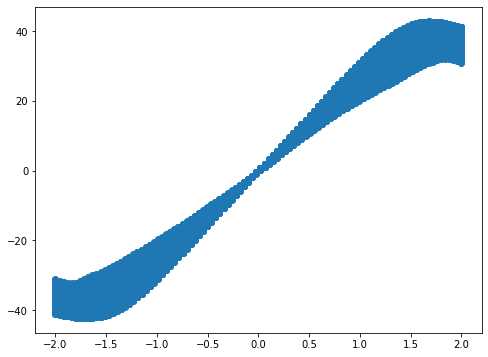

In [12]:
import matplotlib.pyplot as plt

plt.set_cmap('viridis')
plt.figure(figsize=[8,6])

z = gradient[:,0]
plt.scatter(xtest[:,1],gradient[:,1])
#plt.title("p, predictions")
#plt.colorbar()
#plt.savefig("pred.png")
plt.show()

In [21]:
def x_cons():
    x = 0.99
    y = np.linspace(-1, 1, 50)
    return torch.tensor([ [x,x2, 0.] for x2 in y ], dtype = torch.float32)

In [22]:
x_constant = x_cons()

In [23]:
gradient_net_x_const = gradient_net(x_constant, torchNet)

<Figure size 432x288 with 0 Axes>

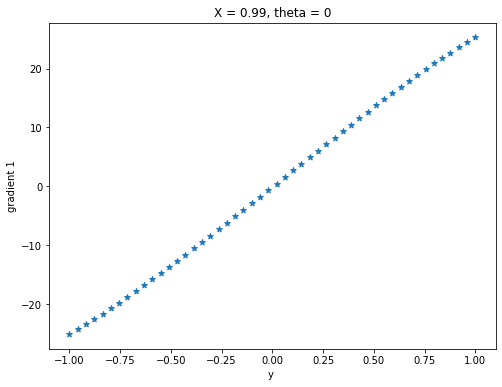

In [28]:
import matplotlib.pyplot as plt

plt.set_cmap('viridis')
plt.figure(figsize=[8,6])

z = gradient[:,0]
plt.scatter(x_constant[:,1],gradient_net_x_const[:,1], marker ="*")
plt.title("X = 0.99, theta = 0")
plt.xlabel('y ')
plt.ylabel('gradient 1')
#plt.colorbar()
plt.savefig("gradpiece1.png")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
scale = .01
xs=[ np.array([x,y,0]) for x in np.arange(-1,1,scale) for y in np.arange(-1,1,scale) ]

def cost(x):
    x = torch.tensor(x, dtype=torch.float32)
    return torchNet(x).detach().numpy()

def grad(x):
    x = torch.tensor(x, dtype=torch.float32)
    x.requires_grad=True
    grad = jacobian(torchNet(x), x).detach().numpy().tolist()
    return grad


print('compute costs')
costs = [cost(x) for x in xs]
print('compute grad')
grads = [grad(x) for x in xs]

"""
plt.clf()
plt.subplot(3,1,1)
plt.scatter([x for x,y,t in xs],[y for x,y,t in xs],c=costs)
plt.colorbar()
plt.title('cost')
plt.subplot(3,1,2)
plt.scatter([x for x,y,t in xs],[y for x,y,t in xs],c=[g[0] for g in grads],vmin=-30,vmax=30)
plt.colorbar()
plt.title('dl/dx0')
plt.subplot(3,1,3)
plt.scatter([x for x,y,t in xs],[y for x,y,t in xs],c=[g[1] for g in grads],vmin=-30,vmax=30)
plt.title('dl/dx1')
plt.colorbar()

plt.figure(2)
plt.plot([y for x,y,z in xs[-200:]], [g[1] for g in grads[-200:]],'+')
plt.title('grad[1] for x=%.2f,th=%.2f'% (xs[-1][0],xs[-1][2]))
"""

In [ ]:
grads